# Benchmark Analysis - H4

In [73]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [74]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [75]:
matplotlib.style.use('seaborn-v0_8')  

In [76]:
device_name = 'hydrac'
core_list = [1,2,4,8,16,32]

In [77]:
root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'

In [78]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [79]:
plot_save_dir = './plots/h4'

## Utils 

In [80]:
def get_path(*entries):
    return os.path.join(*entries)

In [81]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [82]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [83]:
def extraction_pandas_frame_algo(path, COMP="TODO",include_bytes_per_second=False):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                    axis=1)

    if not include_bytes_per_second:
        df = df.drop(columns=['bytes_per_second'])

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev','max','min'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 5 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 5 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    # set max bytes per second
    results_gcc['max_id'] = results_gcc['C'] * 5 + 3
    
    # max bytes per seconds as bytes per second
    if include_bytes_per_second:
        results_gcc['bytes_per_second'] = results_gcc['max_id'].apply(lambda x: df.iloc[x]['bytes_per_second'])

    # min time as real_time
    results_gcc['min_id'] = results_gcc['C'] * 5 + 4
    results_gcc['real_time'] = results_gcc['min_id'].apply(lambda x: df.iloc[x]['real_time'])


    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id','min_id','max_id'], axis=1)
    results_gcc['Compiler'] = 'COMP'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [84]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [85]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [86]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [87]:
def bytes_per_second_data_algo(compiler_location:str,compiler_name:str,benchmark_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{benchmark_name}__Default.csv',COMP=compiler_name,include_bytes_per_second=True)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','real_time'])

    # calc  Mbytes/s
    df[f'{compiler_name}'] = df['bytes_per_second'] * pow(10,-6) # 
    df = df.drop(columns=['bytes_per_second'])
    
    return df

In [88]:

def get_seq_base(benchmark_name:str) -> pd.DataFrame:

    time_filed_name = 'real_time'

    compiler_instances = [
        ('GCC_TBB','GCC(TBB)'),
        ('NVHPC_Multicore','NVC(OMP)')
    ]

    start_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[0][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
    min_val = start_df[time_filed_name].min()
    min_df = start_df


    for i in range(1,len(compiler_instances)):
        current_df = extraction_pandas_frame_algo(f'{root_dir}/{compiler_instances[i][0]}/DEFAULT/{benchmark_name}_seq__Default.csv')
        current_min = current_df[time_filed_name].min()

        if current_min < min_val:
            min_val = current_min
            min_df = current_df

    return min_df

# H4
> Different compilers/backends may fallback to sequential algorithms, leading to better performance.

## `b4_1_merge_cutoff_wrapper_par`

### Time Comparison - `b4_1_merge_cutoff_wrapper_par`


Check how the runtime without constraining the threads develops with increasing input size

In [89]:
def get_b4_1_merge_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_1_merge_cutoff_wrapper_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_data_algo(*x) for x in instances]


# merge for plotting 
b4_1_merge_time_merged = pd.merge(*data, on='n')

b4_1_merge_time_merged

,GCC(TBB),n,NVC(OMP)
0,4.227530e+01,4,5.011130e+03
1,5.294010e+01,8,5.094200e+03
2,7.488240e+01,16,5.613440e+03
3,1.213380e+02,32,5.896820e+03
4,2.313690e+02,64,6.748950e+03
5,4.058220e+02,128,5.881290e+03
6,7.629100e+02,256,6.054250e+03
7,1.485950e+03,512,7.264110e+03
8,5.445250e+03,1024,8.439330e+03
9,9.023030e+03,2048,1.031050e+04


### Strong Scaling - `b4_1_merge_cutoff_wrapper_par`
 
1 Million fixed input size with threads 1-64

In [90]:
def get_b4_1_merge_cutoff_wrapper_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_1_merge_cutoff_wrapper')
    
    ## b4_1_merge_cutoff_wrapper_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_1_merge_cutoff_wrapper_par',
                                               core_list,
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_1_merge_cutoff_wrapper_scaling_algo(*x) for x in instances]

b4_1_merge_cutoff_wrapper_strong_scaling_merged = pd.merge(*data, on='threads')


b4_1_merge_cutoff_wrapper_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.533775,0.755429
1,2,1.040537,0.848880
2,4,1.862648,0.879776
3,8,3.895258,0.928972
4,16,6.005546,0.935564
5,32,6.435082,0.926733


In [91]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_1_merge_cutoff_wrapper_efficiency = b4_1_merge_cutoff_wrapper_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] = b4_1_merge_cutoff_wrapper_efficiency[f'{compiler_name}'] / b4_1_merge_cutoff_wrapper_efficiency['threads']
    

b4_1_merge_cutoff_wrapper_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.533775,0.755429
1,2,0.520268,0.424440
2,4,0.465662,0.219944
3,8,0.486907,0.116121
4,16,0.375347,0.058473
5,32,0.201096,0.028960


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/1363184798.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


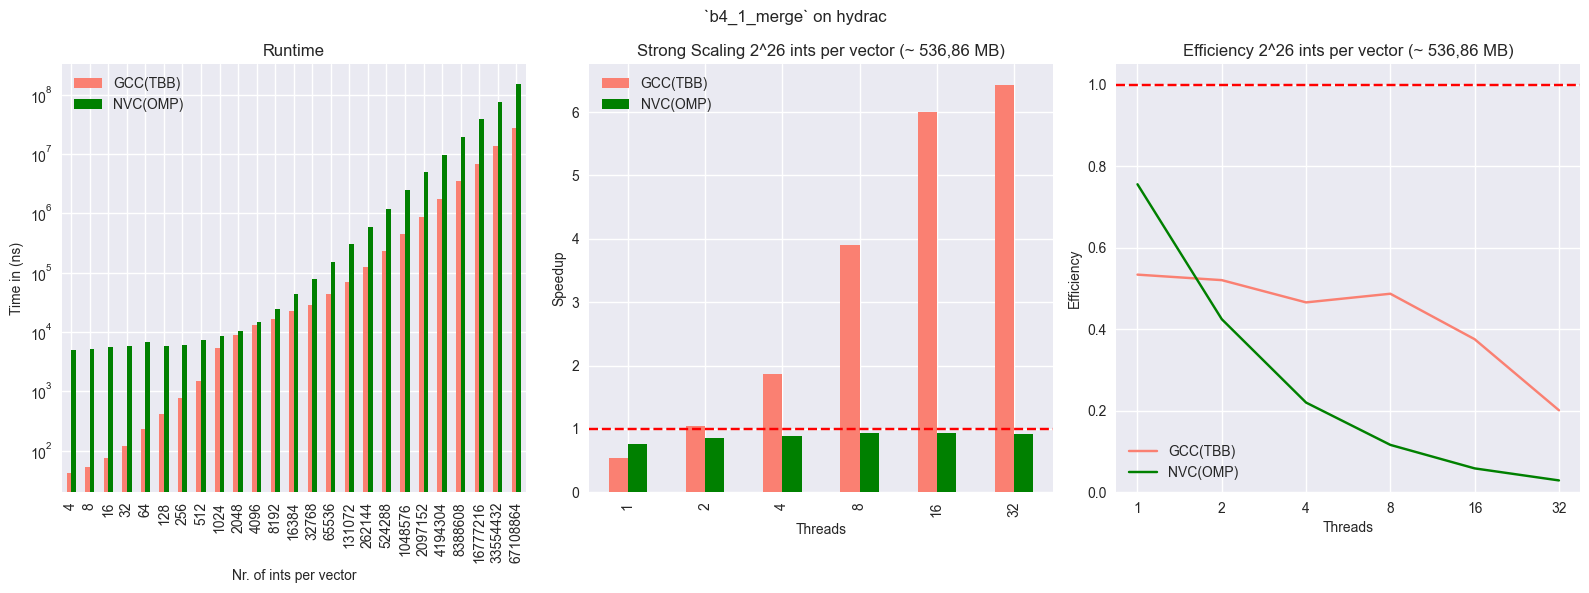

In [92]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b4_1_merge_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints per vector')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b4_1_merge_cutoff_wrapper_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints per vector (~ 536,86 MB)')






# plot efficiency
ax_3 = b4_1_merge_cutoff_wrapper_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints per vector (~ 536,86 MB)')



fig.suptitle(f"`b4_1_merge` on {device_name}")

fig.tight_layout()

plot(f"`b4_1_merge` {device_name}")

### Mbytes/Seconds

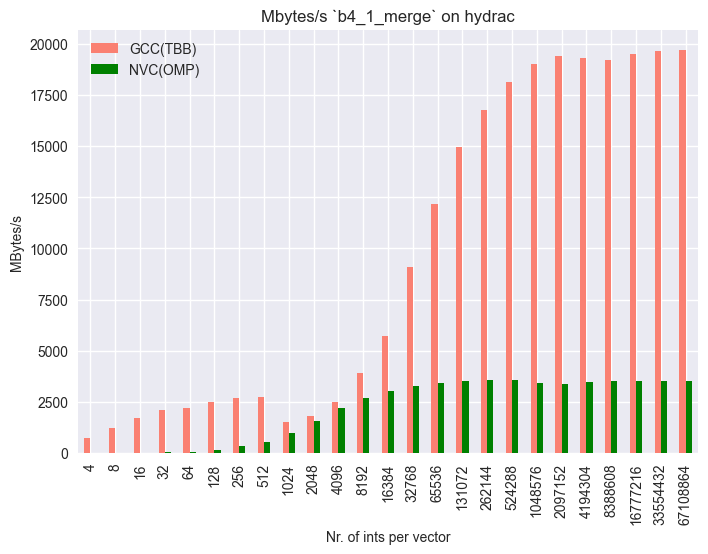

In [93]:
benchmark_name= 'b4_1_merge_cutoff_wrapper_par'
instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

b4_1_mbytes_sec_data = pd.merge(*data, on='n')

# plot mbytes
b4_1_mbytes_sec_data.plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR]
                                                    )


plt.ylabel('MBytes/s')
plt.xlabel('Nr. of ints per vector')
plt.title(f'Mbytes/s `b4_1_merge` on {device_name}')


plot(f'`b4_1_merge` Mbytes_s on {device_name}')

## `b4_2_stable_sort`


### Time Comparison - `b4_2_stable_sort_cutoff_already_sorted_par`

Check how the runtime without constraining the threads develops with increasing input size

In [94]:
def get_b4_2_stable_sort_cutoff_already_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_already_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_already_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_already_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.016600e+02,4,18181.2
1,1.161950e+02,8,22808.9
2,1.895580e+02,16,29108.2
3,2.590700e+02,32,35957.9
4,5.755660e+02,64,42259.6
5,9.375730e+02,128,42708.9
6,2.349050e+03,256,42268.8
7,7.376220e+03,512,43119.9
8,1.145670e+04,1024,45273.4
9,1.548200e+04,2048,47098.7


### Time Comparison - `b4_2_stable_sort_cutoff_decrement_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [95]:
def b4_2_stable_sort_cutoff_decrement_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_decrement_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_decrement_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_decrement_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_decrement_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.017580e+02,4,16319.8
1,1.164080e+02,8,21096.6
2,1.900180e+02,16,25799.5
3,2.596420e+02,32,34613.4
4,5.748410e+02,64,36542.0
5,9.389120e+02,128,34156.6
6,2.341890e+03,256,35109.2
7,7.564600e+03,512,34942.2
8,1.150640e+04,1024,37261.4
9,1.557980e+04,2048,41335.1


### Time Comparison - `b4_2_stable_sort_cutoff_not_sorted_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [96]:
def b4_2_stable_sort_cutoff_not_sorted_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_2_stable_sort_cutoff_not_sorted_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_2_stable_sort_cutoff_not_sorted_data_algo(*x) for x in instances]


# merge for plotting
b4_2_stable_sort_cutoff_not_sorted_time_merged = pd.merge(*data, on='n')

b4_2_stable_sort_cutoff_not_sorted_time_merged

,GCC(TBB),n,NVC(OMP)
0,1.033520e+02,4,17207.3
1,1.167890e+02,8,21455.7
2,1.916970e+02,16,34151.8
3,2.624890e+02,32,38140.3
4,5.823130e+02,64,37275.1
5,9.482400e+02,128,39407.7
6,2.356060e+03,256,40066.1
7,7.521840e+03,512,41237.4
8,1.178460e+04,1024,41834.8
9,1.557570e+04,2048,46165.3


### Strong Scaling - `b4_2_stable_sort_cutoff_already_sorted_par`

In [97]:
def get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_already_sorted')
    
    
    ## b4_2_stable_sort_cutoff_already_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_already_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                            )
    
    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_already_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,2.515798,0.267997
1,2,5.001719,0.502546
2,4,9.927543,0.918013
3,8,19.715123,1.660581
4,16,38.002366,2.415656
5,32,69.627272,2.690878


In [98]:
# efficiency b4_2_stable_sort_cutoff_already_sorted_par
b4_2_stable_sort_cutoff_already_sorted_efficiency = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_already_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_already_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_already_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,2.515798,0.267997
1,2,2.500860,0.251273
2,4,2.481886,0.229503
3,8,2.464390,0.207573
4,16,2.375148,0.150978
5,32,2.175852,0.084090


### Strong Scaling - `b4_2_stable_sort_cutoff_decrement_sorted_par`

1 Million fixed input size with threads 1-64

In [99]:
def get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_decrement_sorted')
    
    
    ## b4_2_stable_sort_cutoff_decrement_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_decrement_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_decrement_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.018180,0.298843
1,2,1.985431,0.558547
2,4,3.781258,0.986112
3,8,12.610624,1.775884
4,16,32.717518,2.572239
5,32,63.109182,2.940482


In [100]:
# efficiency b4_2_stable_sort_cutoff_decrement_sorted_par
b4_2_stable_sort_cutoff_decrement_sorted_efficiency = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_decrement_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_decrement_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_decrement_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.018180,0.298843
1,2,0.992716,0.279273
2,4,0.945315,0.246528
3,8,1.576328,0.221985
4,16,2.044845,0.160765
5,32,1.972162,0.091890


### Strong Scaling - `b4_2_stable_sort_cutoff_not_sorted_par`

1 Million fixed input size with threads 1-64

In [101]:
def get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_2_stable_sort_cutoff_not_sorted')
    
    
    ## b4_2_stable_sort_cutoff_not_sorted_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_2_stable_sort_cutoff_not_sorted_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_2_stable_sort_cutoff_not_sorted_scaling_algo(*x) for x in instances]

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged = pd.merge(*data, on='threads')

b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.930192,7.038827
1,2,1.848561,8.479437
2,4,3.628011,9.382235
3,8,7.140889,9.859472
4,16,32.775889,10.233115
5,32,131.720824,10.467429


In [102]:
# efficiency b4_2_stable_sort_cutoff_not_sorted_par
b4_2_stable_sort_cutoff_not_sorted_efficiency = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] = b4_2_stable_sort_cutoff_not_sorted_efficiency[f'{compiler_name}'] / b4_2_stable_sort_cutoff_not_sorted_efficiency['threads']



b4_2_stable_sort_cutoff_not_sorted_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.930192,7.038827
1,2,0.924280,4.239719
2,4,0.907003,2.345559
3,8,0.892611,1.232434
4,16,2.048493,0.639570
5,32,4.116276,0.327107


### Plotting

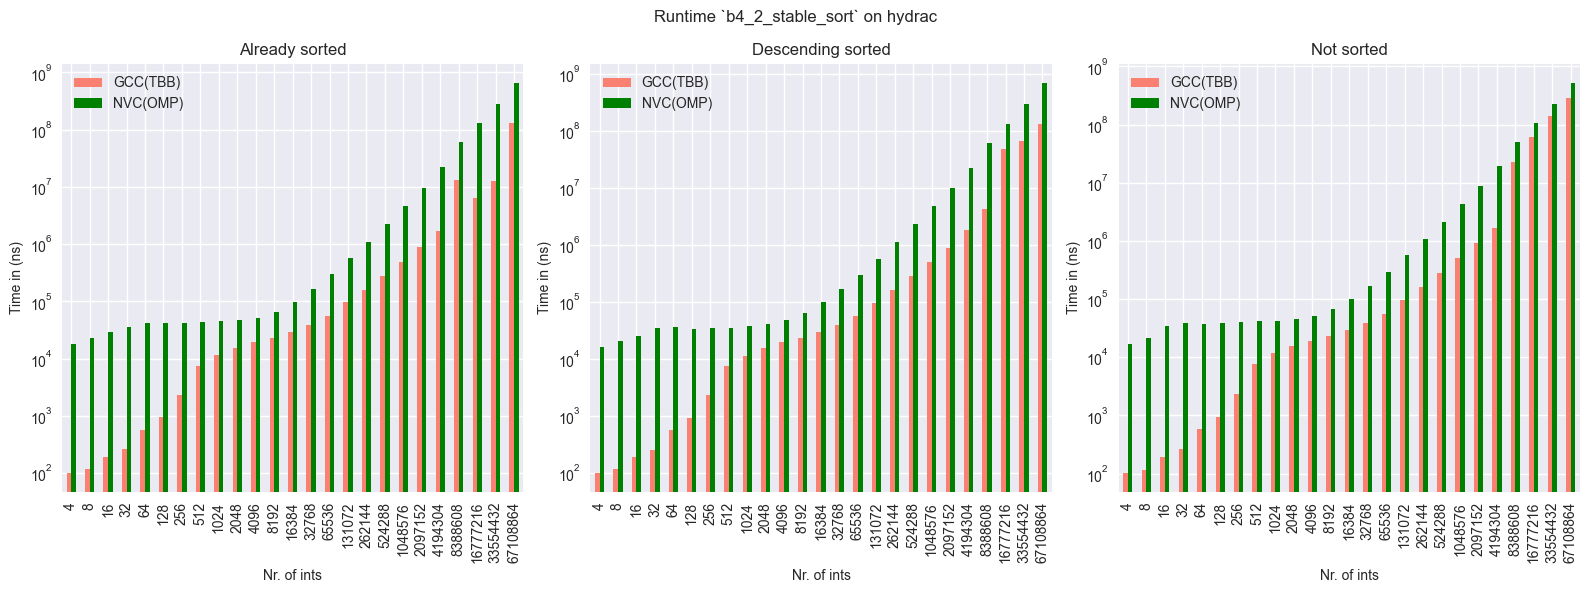

In [103]:
### Runtime

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')

fig.suptitle(f"Runtime `b4_2_stable_sort` on {device_name}")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Runtime on {device_name}")


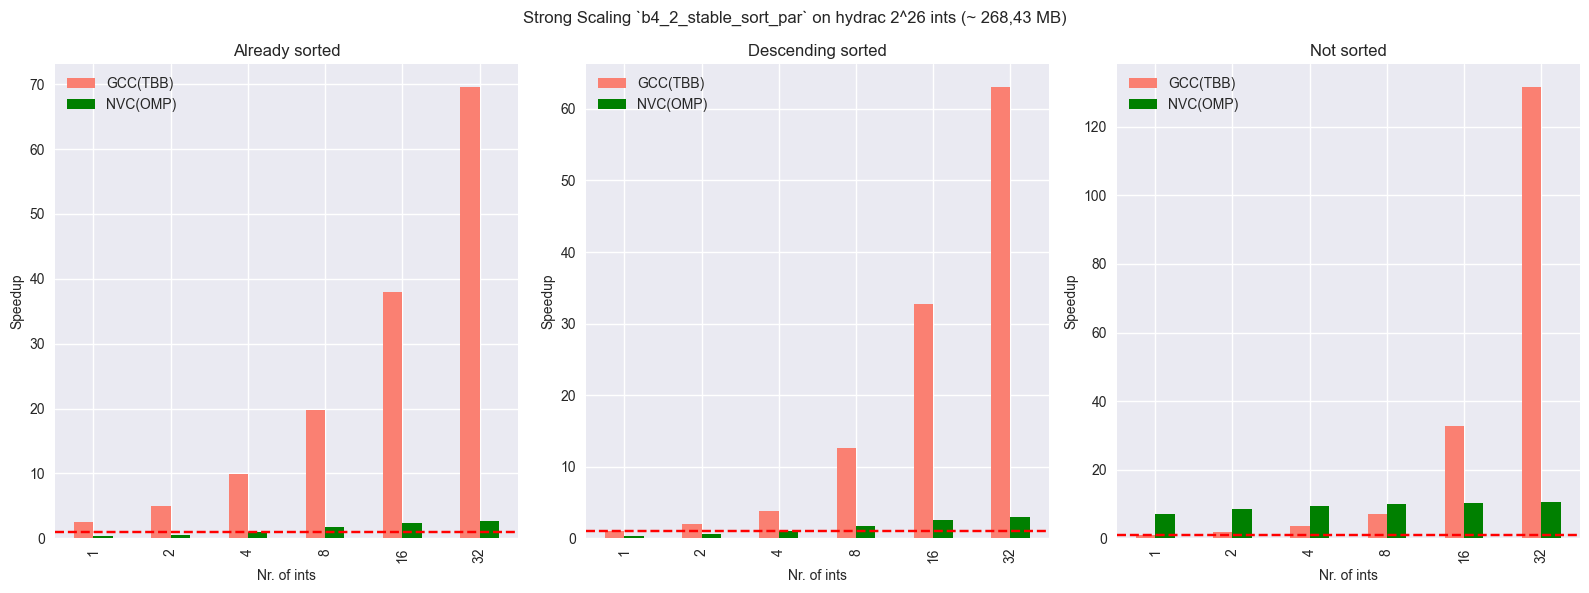

In [104]:
## stable sort strong scaling graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')
ax_2.axhline(y=1,color='r', linestyle='--')


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')

fig.suptitle(f"Strong Scaling `b4_2_stable_sort_par` on {device_name} 2^26 ints (~ 268,43 MB)")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Strong Scaling on {device_name} 2^26 ints (~ 268,43 MB)")


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/3260990570.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/3260990570.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/3260990570.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


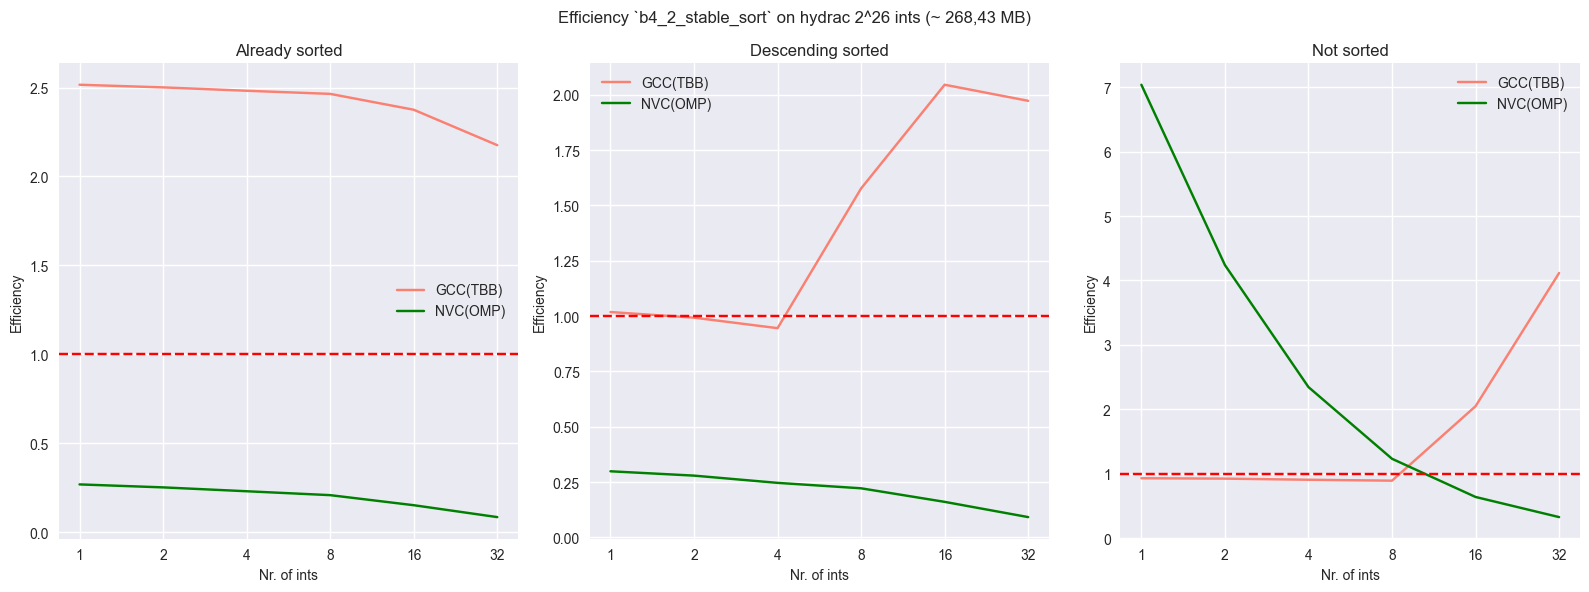

In [105]:
### efficiency stable sort

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_2_stable_sort_cutoff_already_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')
ax_1.axhline(y=1,color='r', linestyle='--')

#ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_2_stable_sort_cutoff_decrement_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')
ax_2.axhline(y=1,color='r', linestyle='--')

#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_2_stable_sort_cutoff_not_sorted_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')
ax_3.axhline(y=1,color='r', linestyle='--')



ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle(f"Efficiency `b4_2_stable_sort` on {device_name} 2^26 ints (~ 268,43 MB)")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Efficiency on {device_name} 2^26 ints (~ 268,43 MB)")

### Mbytes/s

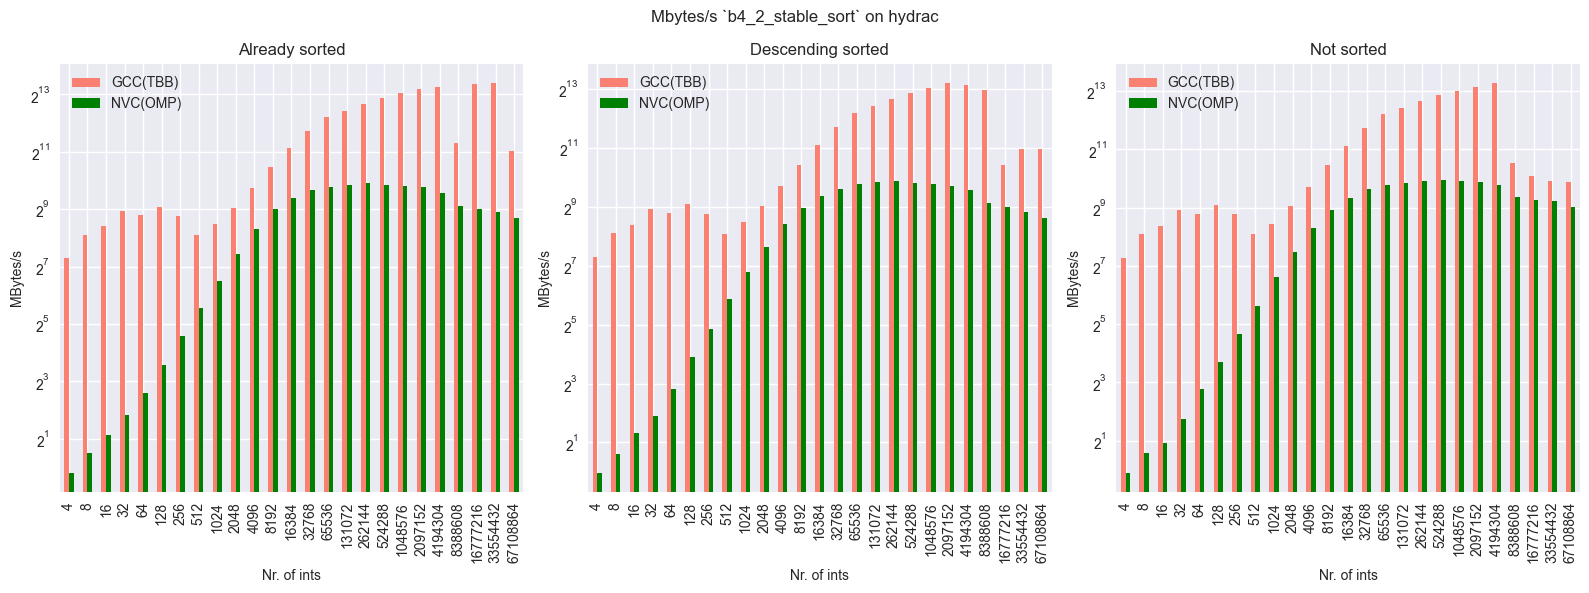

In [106]:
benchmark_names = [
    'b4_2_stable_sort_cutoff_already_sorted_par',
    'b4_2_stable_sort_cutoff_decrement_sorted_par',
    'b4_2_stable_sort_cutoff_not_sorted_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_2_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_2_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))



# plot already sorted
ax_1 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_already_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Already sorted')




# plot decrement_sorted
ax_2 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_decrement_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Descending sorted')


# plot not_sorted
ax_3 = b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_not_sorted_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[2]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints')
ax_3.set_title('Not sorted')


fig.suptitle(f"Mbytes/s `b4_2_stable_sort` on {device_name}")

fig.tight_layout()

plot(f"`b4_2_stable_sort` Mbytes_s on {device_name}")

## `b4_3_set_union`

### Time Comparison - `b4_3_set_union_cutoff_one_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [107]:
def b4_3_set_union_cutoff_one_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_empty_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.207400e+01,4,4872.72
1,3.158560e+01,8,4897.06
2,3.158950e+01,16,5665.89
3,3.384060e+01,32,6022.40
4,3.417650e+01,64,5500.30
5,4.228460e+01,128,5263.43
6,4.918580e+01,256,5194.10
7,6.379730e+01,512,5504.05
8,2.804180e+04,1024,5534.75
9,3.112250e+04,2048,5673.03


### Time Comparison - `b4_3_set_union_cutoff_one_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [108]:
def b4_3_set_union_cutoff_one_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_one_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_one_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_one_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_one_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.897140e+01,4,4.830260e+03
1,4.547890e+01,8,4.826760e+03
2,5.017640e+01,16,5.491680e+03
3,6.732430e+01,32,6.446430e+03
4,9.839930e+01,64,5.621960e+03
5,1.749810e+02,128,5.721620e+03
6,3.050400e+02,256,6.199040e+03
7,3.263900e+04,512,7.017420e+03
8,3.704930e+04,1024,8.399440e+03
9,4.220730e+04,2048,8.970090e+03


### Time Comparison - `b4_3_set_union_cutoff_front_overhang_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [109]:
def b4_3_set_union_cutoff_front_overhang_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_3_set_union_cutoff_front_overhang_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_3_set_union_cutoff_front_overhang_data_algo(*x) for x in instances]


# merge for plotting
b4_3_set_union_cutoff_front_overhang_time_merged = pd.merge(*data, on='n')

b4_3_set_union_cutoff_front_overhang_time_merged

,GCC(TBB),n,NVC(OMP)
0,4.040080e+01,4,4.844880e+03
1,4.803780e+01,8,4.840490e+03
2,6.740710e+01,16,4.920620e+03
3,1.061670e+02,32,5.357440e+03
4,1.979660e+02,64,6.292540e+03
5,3.472760e+02,128,5.651770e+03
6,6.742080e+02,256,5.684330e+03
7,7.158920e+04,512,6.933280e+03
8,7.841050e+04,1024,8.051340e+03
9,8.636620e+04,2048,9.025350e+03


### Strong Scaling - `b4_3_set_union_cutoff_one_empty_par`

1 Million fixed input size with threads 1-64

In [110]:
def get_b4_3_set_union_cutoff_one_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = get_seq_base('b4_3_set_union_cutoff_one_empty')
    
    ## b4_3_set_union_cutoff_one_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_empty_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.982028,0.782363
1,2,1.951564,1.532535
2,4,3.723501,2.949881
3,8,6.351260,4.924249
4,16,7.422187,7.757877
5,32,7.115413,9.394776


In [111]:
# efficiency b4_3_set_union_cutoff_one_empty_par
b4_3_set_union_cutoff_one_empty_efficiency = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_empty_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_empty_efficiency['threads']



b4_3_set_union_cutoff_one_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.982028,0.782363
1,2,0.975782,0.766268
2,4,0.930875,0.737470
3,8,0.793908,0.615531
4,16,0.463887,0.484867
5,32,0.222357,0.293587


### Strong Scaling - `b4_3_set_union_cutoff_one_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [112]:
def get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_3_set_union_cutoff_one_wholly_greater')
    
    ## b4_3_set_union_cutoff_one_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_one_wholly_greater_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_one_wholly_greater_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.113005,0.734507
1,2,2.163759,0.916813
2,4,4.061061,1.051736
3,8,7.206271,1.133806
4,16,7.887111,1.144928
5,32,7.852041,1.126811


In [113]:

# efficiency b4_3_set_union_cutoff_one_wholly_greater_par
b4_3_set_union_cutoff_one_wholly_greater_efficiency = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_one_wholly_greater_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_one_wholly_greater_efficiency['threads']



b4_3_set_union_cutoff_one_wholly_greater_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.113005,0.734507
1,2,1.081879,0.458407
2,4,1.015265,0.262934
3,8,0.900784,0.141726
4,16,0.492944,0.071558
5,32,0.245376,0.035213


### Strong Scaling - `b4_3_set_union_cutoff_front_overhang_par`

1 Million fixed input size with threads 1-64

In [114]:
def get_b4_3_set_union_cutoff_front_overhang_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_3_set_union_cutoff_front_overhang')
    
    ## b4_3_set_union_cutoff_front_overhang_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_3_set_union_cutoff_front_overhang_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_3_set_union_cutoff_front_overhang_scaling_algo(*x) for x in instances]

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged = pd.merge(*data, on='threads')

b4_3_set_union_cutoff_front_overhang_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.465629,0.862320
1,2,0.849473,0.970086
2,4,1.342548,1.038254
3,8,1.538832,1.063125
4,16,1.402998,1.078728
5,32,1.387710,1.045719


In [115]:
# efficiency b4_3_set_union_cutoff_front_overhang_par
b4_3_set_union_cutoff_front_overhang_efficiency = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] = b4_3_set_union_cutoff_front_overhang_efficiency[f'{compiler_name}'] / b4_3_set_union_cutoff_front_overhang_efficiency['threads']



b4_3_set_union_cutoff_front_overhang_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.465629,0.862320
1,2,0.424737,0.485043
2,4,0.335637,0.259563
3,8,0.192354,0.132891
4,16,0.087687,0.067420
5,32,0.043366,0.032679


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/1367863599.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_1.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/1367863599.py:23: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_2.set_ylim(0,y_lim)
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/1367863599.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax_3.set_ylim(0,y_lim)


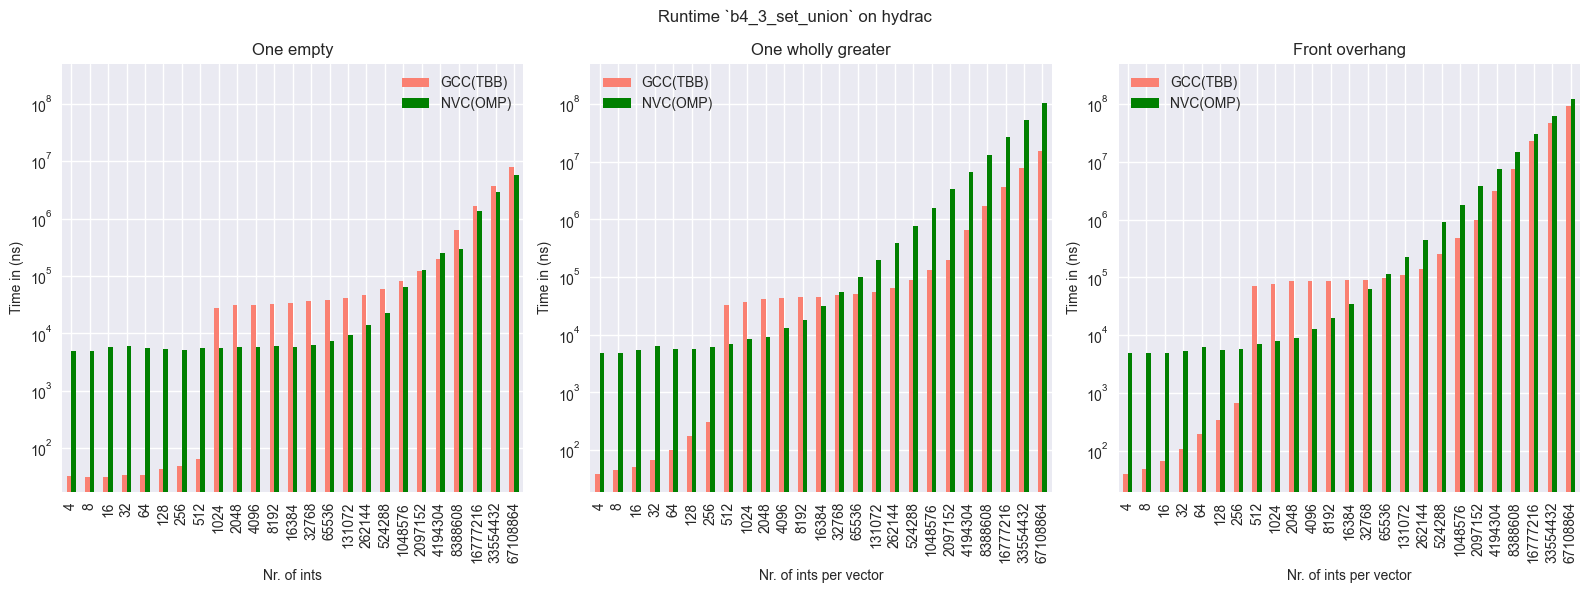

In [116]:
# all set_union graphs

y_lim = 5*pow(10,8)
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('One empty')
ax_1.set_ylim(0,y_lim)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('One wholly greater')
ax_2.set_ylim(0,y_lim)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Front overhang')
ax_3.set_ylim(0,y_lim)

fig.suptitle(f"Runtime `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Runtime on {device_name}")

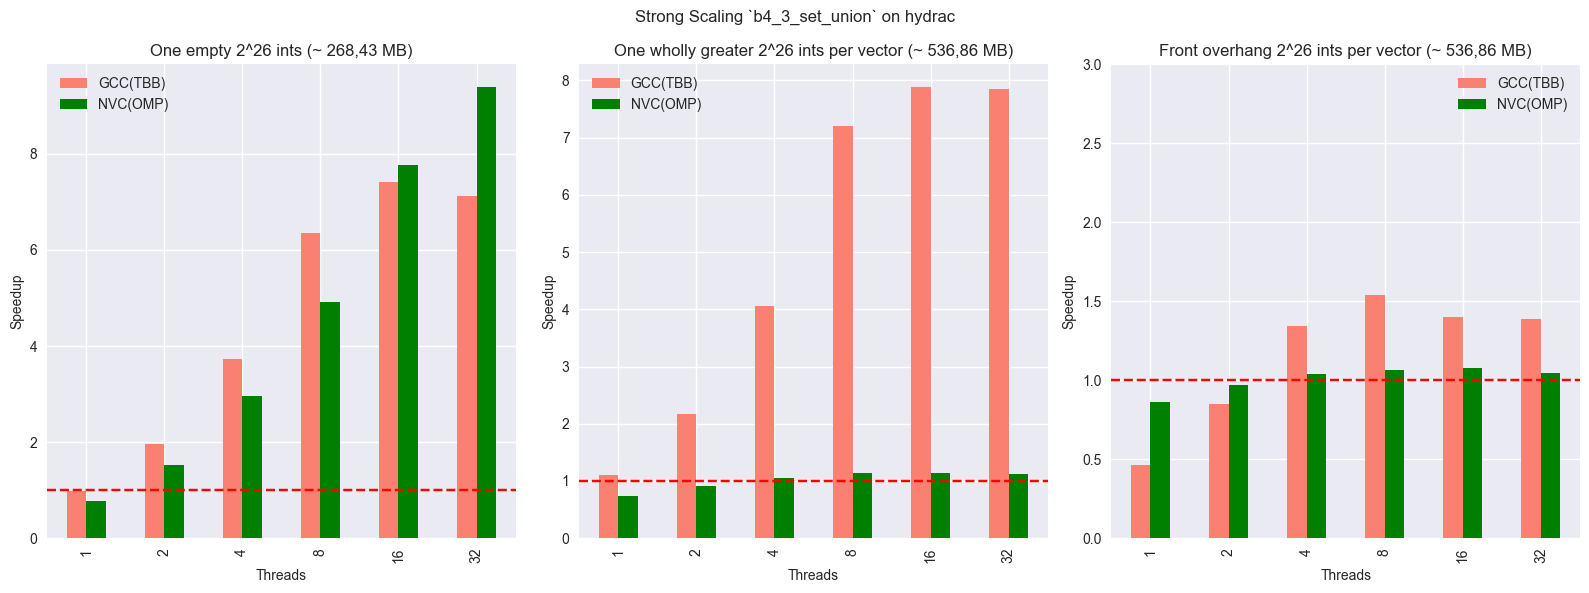

In [117]:
# all set_union graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('One empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
#ax_1.set_ylim(0,3)

# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('One wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,3)


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Front overhang 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,3)


fig.suptitle(f"Strong Scaling `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Strong Scaling on {device_name}")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/2777024957.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/2777024957.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/2777024957.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


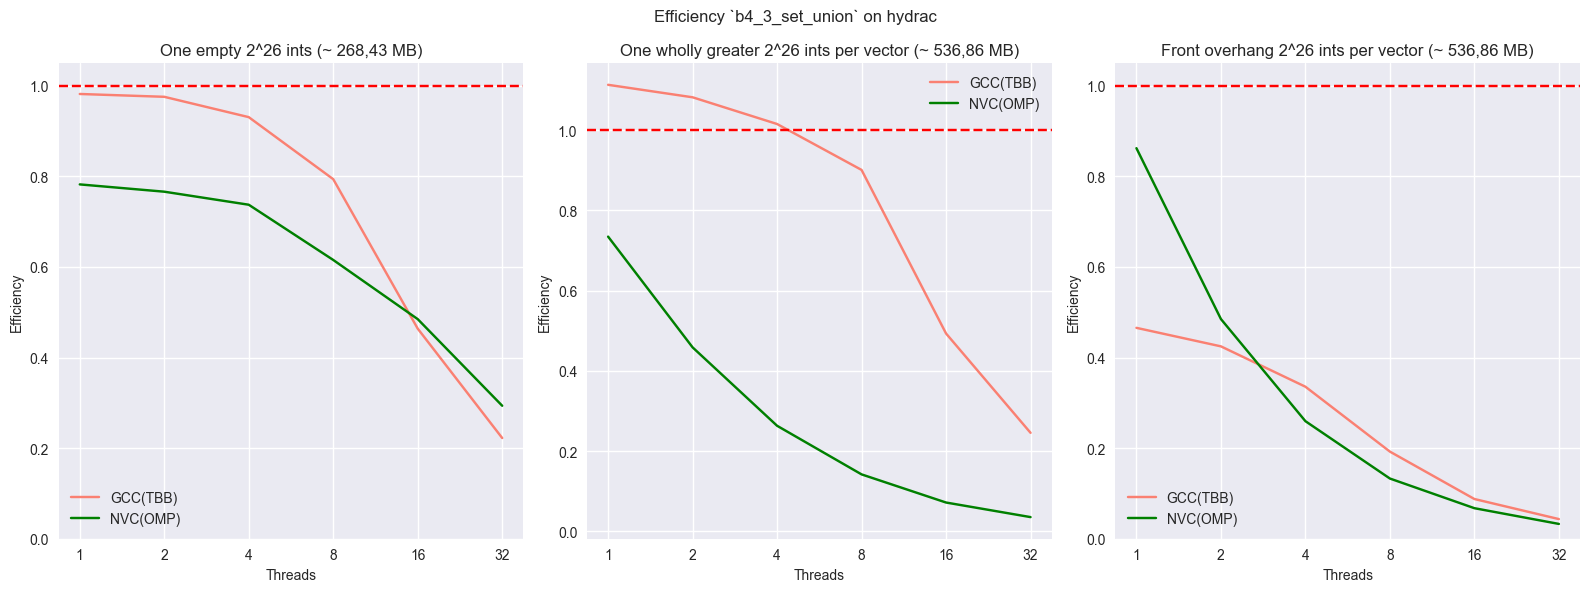

In [118]:
# efficiency  set_union graphs


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# already sorted
ax_1 = b4_3_set_union_cutoff_one_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Threads')
ax_1.set_title('One empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# decrement sorted
ax_2 = b4_3_set_union_cutoff_one_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Threads')
ax_2.set_title('One wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# not sorted
ax_3 = b4_3_set_union_cutoff_front_overhang_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[2])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Front overhang 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
ax_3.set_ylim(0,1.05)

ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


fig.suptitle(f"Efficiency `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Efficiency on {device_name}")

### Mbytes/s

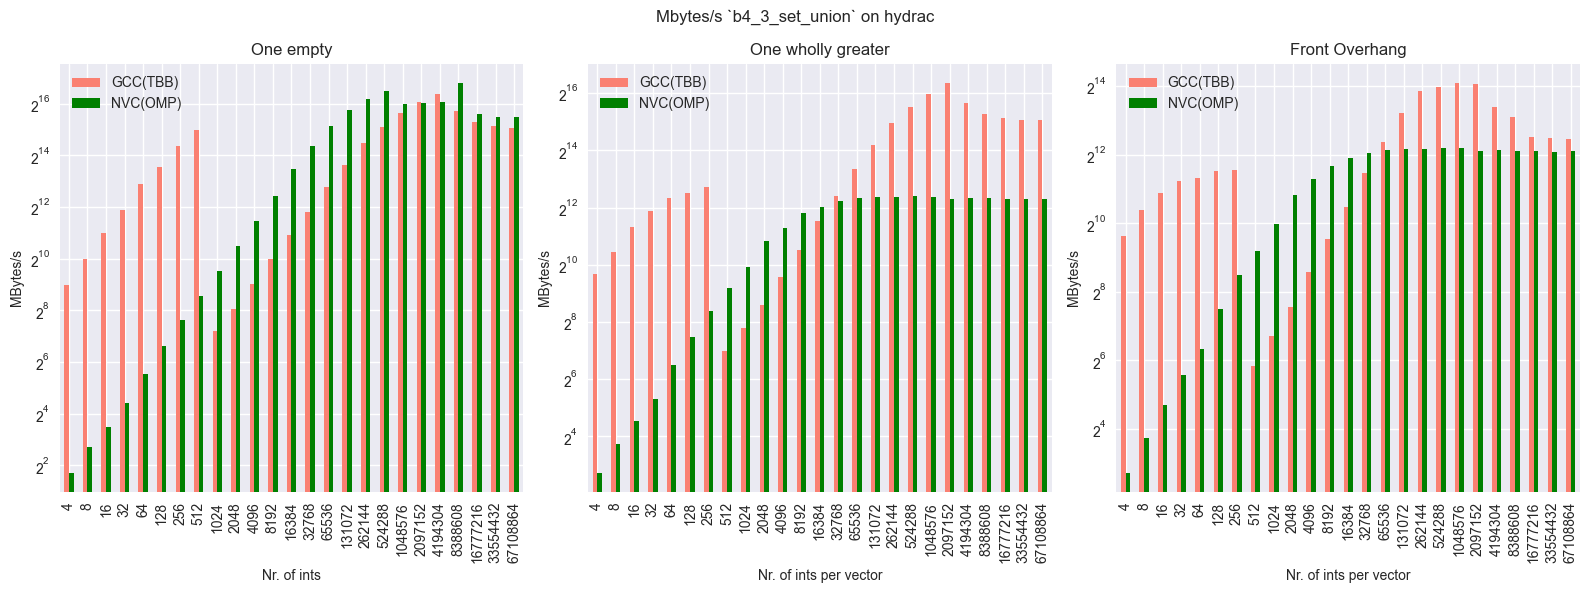

In [119]:
benchmark_names = [
    'b4_3_set_union_cutoff_one_empty_par',
    'b4_3_set_union_cutoff_one_wholly_greater_par',
    'b4_3_set_union_cutoff_front_overhang_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_3_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_3_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')


fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))

#ylim = (0,pow(2,15))


# plot one empty
ax_1 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('One empty')
#ax_1.set_ylim(0,2*pow(2,14))



# plot wholey greater
ax_2 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_wholly_greater_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints per vector')
ax_2.set_title('One wholly greater')
#ax_2.set_ylim(*ylim)


# plot front_overhang
ax_3 = b4_3_mbytes_sec_data['b4_3_set_union_cutoff_front_overhang_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[2]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Front Overhang')
#ax_3.set_ylim(*ylim)


fig.suptitle(f"Mbytes/s `b4_3_set_union` on {device_name}")

fig.tight_layout()

plot(f"`b4_3_set_union` Mbytes_s on {device_name}")

## `b4_4_set_difference`

### Time Comparison - `b4_4_set_difference_cutoff_left_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [120]:
def b4_4_set_difference_cutoff_left_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_left_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_left_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_left_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_left_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,34.3759,4,37.4831
1,34.3828,8,37.6347
2,34.3976,16,37.6820
3,34.3961,32,37.7001
4,34.3971,64,37.7073
5,34.3973,128,37.7036
6,34.3959,256,37.6915
7,34.3980,512,37.6870
8,34.3991,1024,37.6641
9,34.3947,2048,37.6071


### Time Comparison - `b4_4_set_difference_cutoff_right_empty_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [121]:
def b4_4_set_difference_cutoff_right_empty_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_right_empty_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_right_empty_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_right_empty_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_right_empty_time_merged

,GCC(TBB),n,NVC(OMP)
0,2404.01,4,4998.91
1,4941.43,8,5321.98
2,9113.10,16,5428.75
3,13483.90,32,5996.25
4,17189.20,64,5620.75
5,21319.70,128,5391.47
6,25530.60,256,5316.62
7,26674.20,512,5676.03
8,30168.30,1024,5651.85
9,34737.10,2048,5728.73


### Time Comparison - `b4_4_set_difference_cutoff_wholly_greater_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [122]:
def b4_4_set_difference_cutoff_wholly_greater_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_wholly_greater_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_wholly_greater_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_wholly_greater_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_wholly_greater_time_merged

,GCC(TBB),n,NVC(OMP)
0,2324.49,4,4.085010e+01
1,4942.92,8,4.478190e+01
2,8352.38,16,5.313200e+01
3,12544.20,32,6.807500e+01
4,16911.40,64,9.866000e+01
5,21044.10,128,1.699850e+02
6,24616.70,256,2.922780e+02
7,27683.20,512,5.363880e+02
8,31212.50,1024,1.025600e+03
9,33569.20,2048,2.004300e+03


### Time Comparison - `b4_4_set_difference_cutoff_intersected_par`

Check how the runtime without constraining the threads develops with increasing the input size

In [123]:
def b4_4_set_difference_cutoff_intersected_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    # load b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b4_4_set_difference_cutoff_intersected_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [b4_4_set_difference_cutoff_intersected_data_algo(*x) for x in instances]


# merge for plotting
b4_4_set_difference_cutoff_intersected_time_merged = pd.merge(*data, on='n')

b4_4_set_difference_cutoff_intersected_time_merged

,GCC(TBB),n,NVC(OMP)
0,5.175740e+01,4,4.199420e+01
1,6.883470e+01,8,4.682650e+01
2,9.950840e+01,16,5.611630e+01
3,1.567080e+02,32,7.239360e+01
4,2.679220e+02,64,1.048760e+02
5,5.069140e+02,128,1.781690e+02
6,9.378770e+02,256,3.009020e+02
7,6.960660e+04,512,5.452050e+02
8,7.758100e+04,1024,1.034970e+03
9,7.641040e+04,2048,2.014050e+03


### Strong Scaling - `b4_4_set_difference_cutoff_left_empty_par`

1 Million fixed input size with threads 1-64

In [124]:
def get_b4_4_set_difference_cutoff_left_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_left_empty')
    
    
    ## b4_4_set_difference_cutoff_left_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_left_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_left_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_left_empty_strong_scaling_merged


,threads,GCC(TBB),NVC(OMP)
0,1,0.835383,0.767458
1,2,0.835154,0.721294
2,4,0.835319,0.769573
3,8,0.835472,0.675606
4,16,0.835128,0.761610
5,32,0.835356,0.769044


In [125]:
# efficiency b4_4_set_difference_cutoff_left_empty_par
b4_4_set_difference_cutoff_left_empty_efficiency = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_left_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_left_empty_efficiency['threads']



b4_4_set_difference_cutoff_left_empty_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,0.835383,0.767458
1,2,0.417577,0.360647
2,4,0.208830,0.192393
3,8,0.104434,0.084451
4,16,0.052195,0.047601
5,32,0.026105,0.024033


### Strong Scaling - `b4_4_set_difference_cutoff_right_empty_par`

1 Million fixed input size with threads 1-64

In [126]:
def get_b4_4_set_difference_cutoff_right_empty_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    

    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_right_empty')
    
    ## b4_4_set_difference_cutoff_right_empty_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_right_empty_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_right_empty_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_right_empty_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.984641,0.777052
1,2,1.926497,1.555336
2,4,3.726727,3.029368
3,8,6.347001,4.589265
4,16,7.238860,6.004749
5,32,6.986988,10.541470


In [127]:
# efficiency b4_4_set_difference_cutoff_right_empty_par
b4_4_set_difference_cutoff_right_empty_efficiency = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_right_empty_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_right_empty_efficiency['threads']



b4_4_set_difference_cutoff_right_empty_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.984641,0.777052
1,2,0.963249,0.777668
2,4,0.931682,0.757342
3,8,0.793375,0.573658
4,16,0.452429,0.375297
5,32,0.218343,0.329421


#### Strong Scaling - `b4_4_set_difference_cutoff_wholly_greater_par`

1 Million fixed input size with threads 1-64

In [128]:
def get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
    ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_wholly_greater')
    
    ## b4_4_set_difference_cutoff_wholly_greater_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_wholly_greater_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_wholly_greater_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.235154,0.992881
1,2,2.411400,1.001443
2,4,4.379167,0.991410
3,8,7.973460,0.990527
4,16,9.143856,1.013226
5,32,8.801269,0.913650


In [129]:

# efficiency b4_4_set_difference_cutoff_wholly_greater_par
b4_4_set_difference_cutoff_wholly_greater_efficiency = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_wholly_greater_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_wholly_greater_efficiency['threads']



b4_4_set_difference_cutoff_wholly_greater_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,1.235154,0.992881
1,2,1.205700,0.500722
2,4,1.094792,0.247853
3,8,0.996682,0.123816
4,16,0.571491,0.063327
5,32,0.275040,0.028552


### Strong Scaling - `b4_4_set_difference_cutoff_intersected_par`

1 Million fixed input size with threads 1-64

In [130]:
def get_b4_4_set_difference_cutoff_intersected_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    
     ## seq base
    sq_base = get_seq_base('b4_4_set_difference_cutoff_intersected')
    
    ## b4_4_set_difference_cutoff_intersected_par
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b4_4_set_difference_cutoff_intersected_par',
                                               core_list,
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(sq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b4_4_set_difference_cutoff_intersected_scaling_algo(*x) for x in instances]

b4_4_set_difference_cutoff_intersected_strong_scaling_merged = pd.merge(*data, on='threads')

b4_4_set_difference_cutoff_intersected_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.324540,0.997014
1,2,0.648099,1.000908
2,4,1.290379,0.996171
3,8,2.581642,0.995945
4,16,5.116241,0.989491
5,32,9.444556,0.907176


In [131]:
# efficiency b4_4_set_difference_cutoff_intersected_par
b4_4_set_difference_cutoff_intersected_efficiency = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] = b4_4_set_difference_cutoff_intersected_efficiency[f'{compiler_name}'] / b4_4_set_difference_cutoff_intersected_efficiency['threads']



b4_4_set_difference_cutoff_intersected_efficiency


,threads,GCC(TBB),NVC(OMP)
0,1,0.324540,0.997014
1,2,0.324050,0.500454
2,4,0.322595,0.249043
3,8,0.322705,0.124493
4,16,0.319765,0.061843
5,32,0.295142,0.028349


### Plots

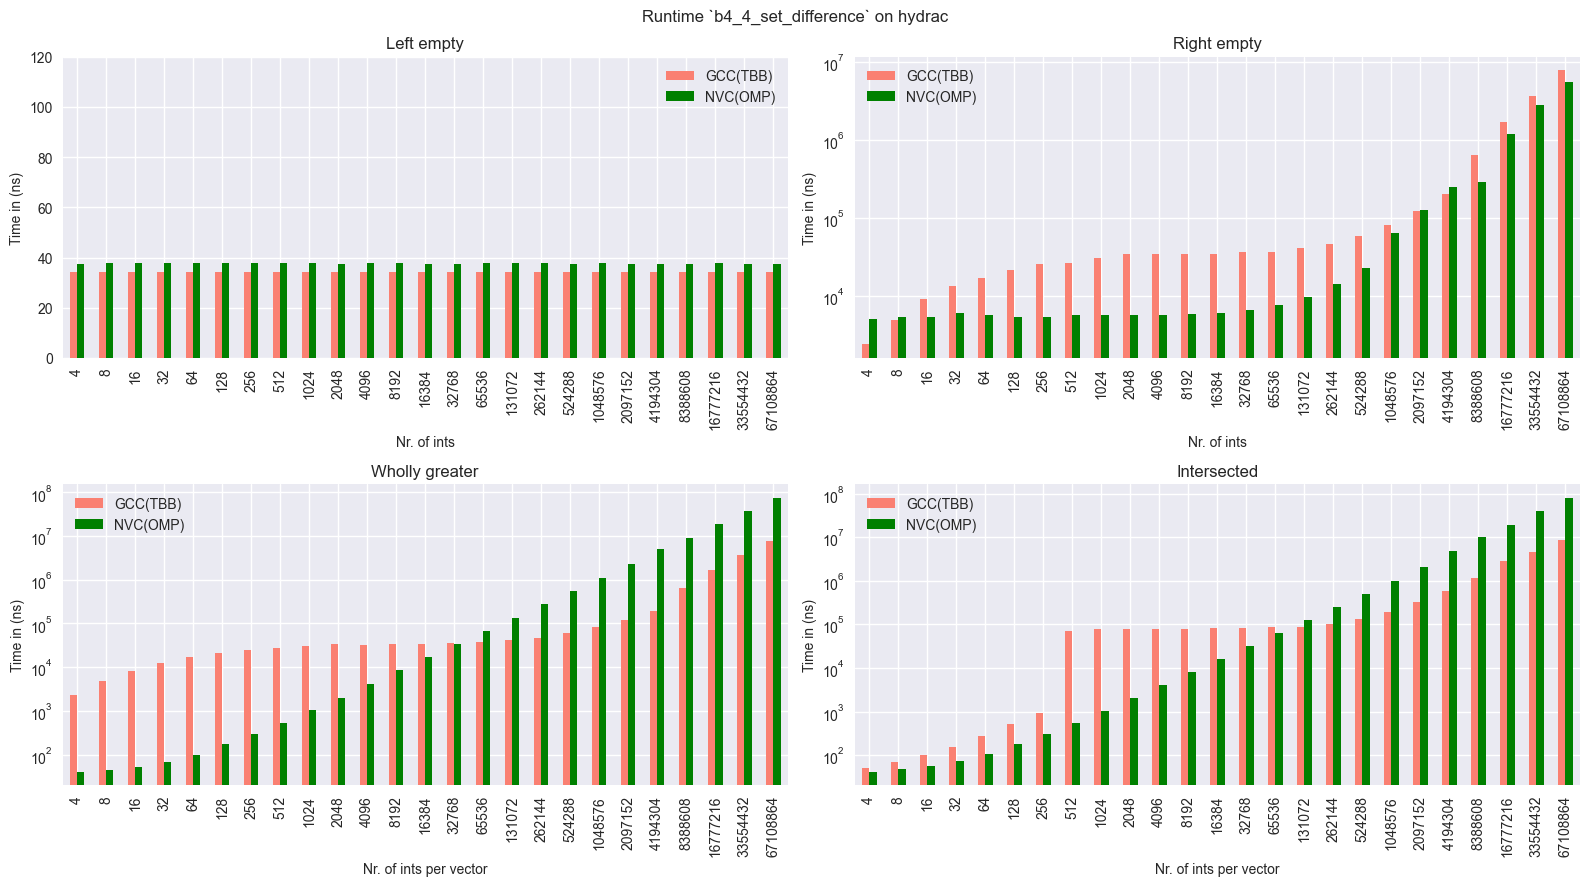

In [132]:
# all set_difference graphs

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Left empty')
ax_1.set_ylim(0,120)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_yscale('log', base=10)
ax_2.set_ylabel('Time in (ns)')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Right empty')


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_yscale('log', base=10)
ax_3.set_ylabel('Time in (ns)')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Wholly greater')


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_yscale('log', base=10)
ax_4.set_ylabel('Time in (ns)')
ax_4.set_xlabel('Nr. of ints per vector')
ax_4.set_title('Intersected')

fig.suptitle(f"Runtime `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Runtime on {device_name}")

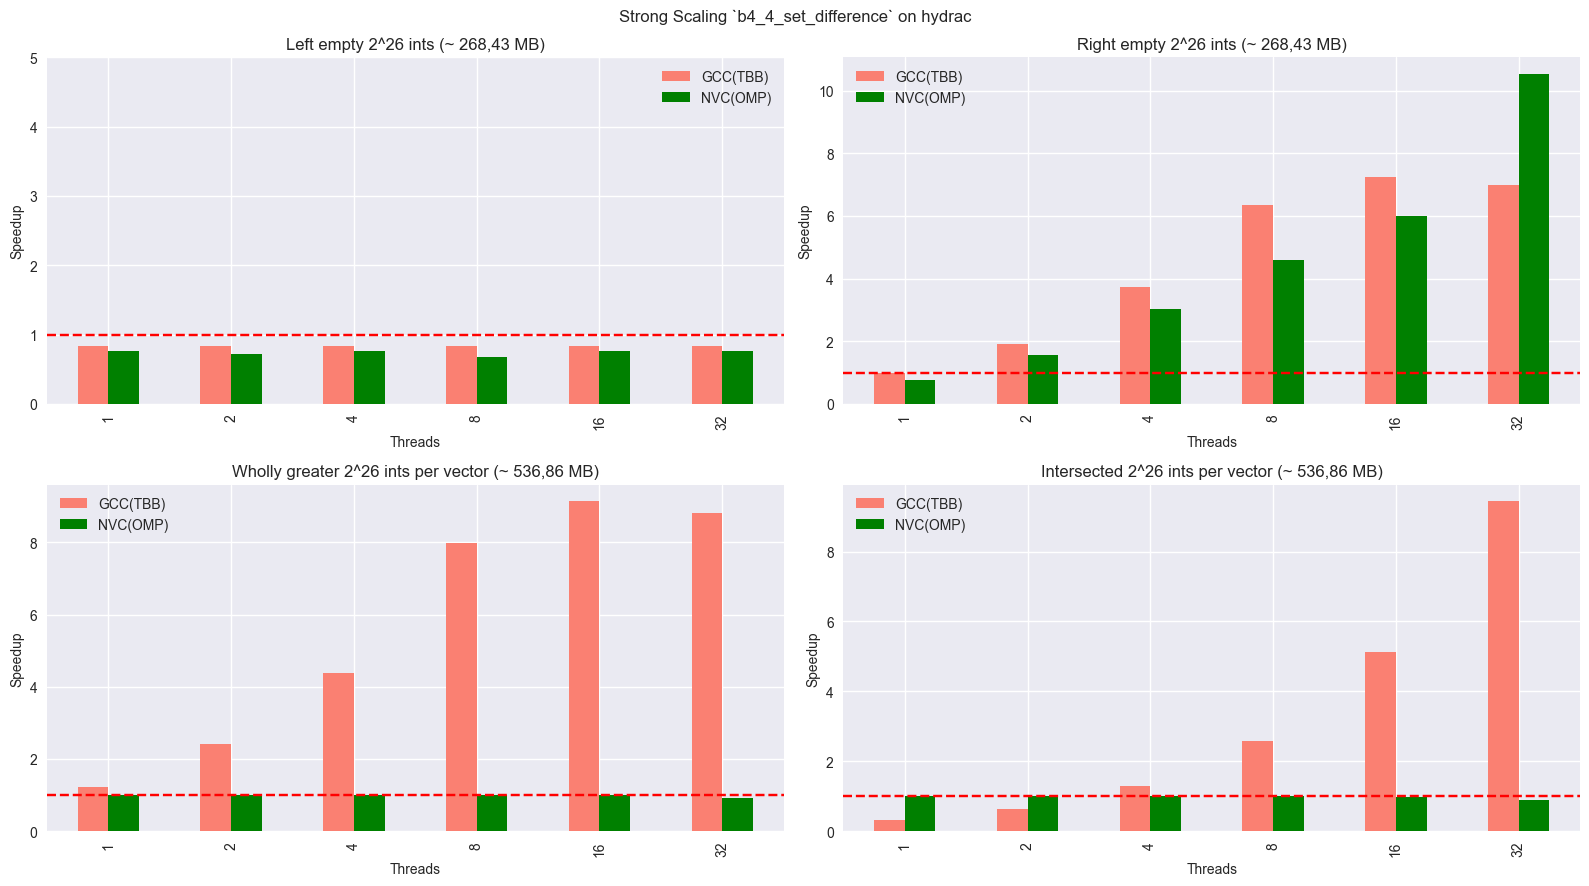

In [133]:
# strong scaling graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Speedup')
ax_1.set_xlabel('Threads')
ax_1.set_title('Left empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,5)

# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Right empty 2^26 ints (~ 268,43 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
#ax_2.set_ylim(0,5)

# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Speedup')
ax_3.set_xlabel('Threads')
ax_3.set_title('Wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')
#ax_3.set_ylim(0,5)

# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_strong_scaling_merged.plot(kind='bar',x='threads',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Speedup')
ax_4.set_xlabel('Threads')
ax_4.set_title('Intersected 2^26 ints per vector (~ 536,86 MB)')
ax_4.axhline(y=1, color='r',linestyle='--')
#ax_4.set_ylim(0,5)

fig.suptitle(f"Strong Scaling `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Strong Scaling on {device_name}")

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/204873550.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/204873550.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/204873550.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_14978/204873550.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


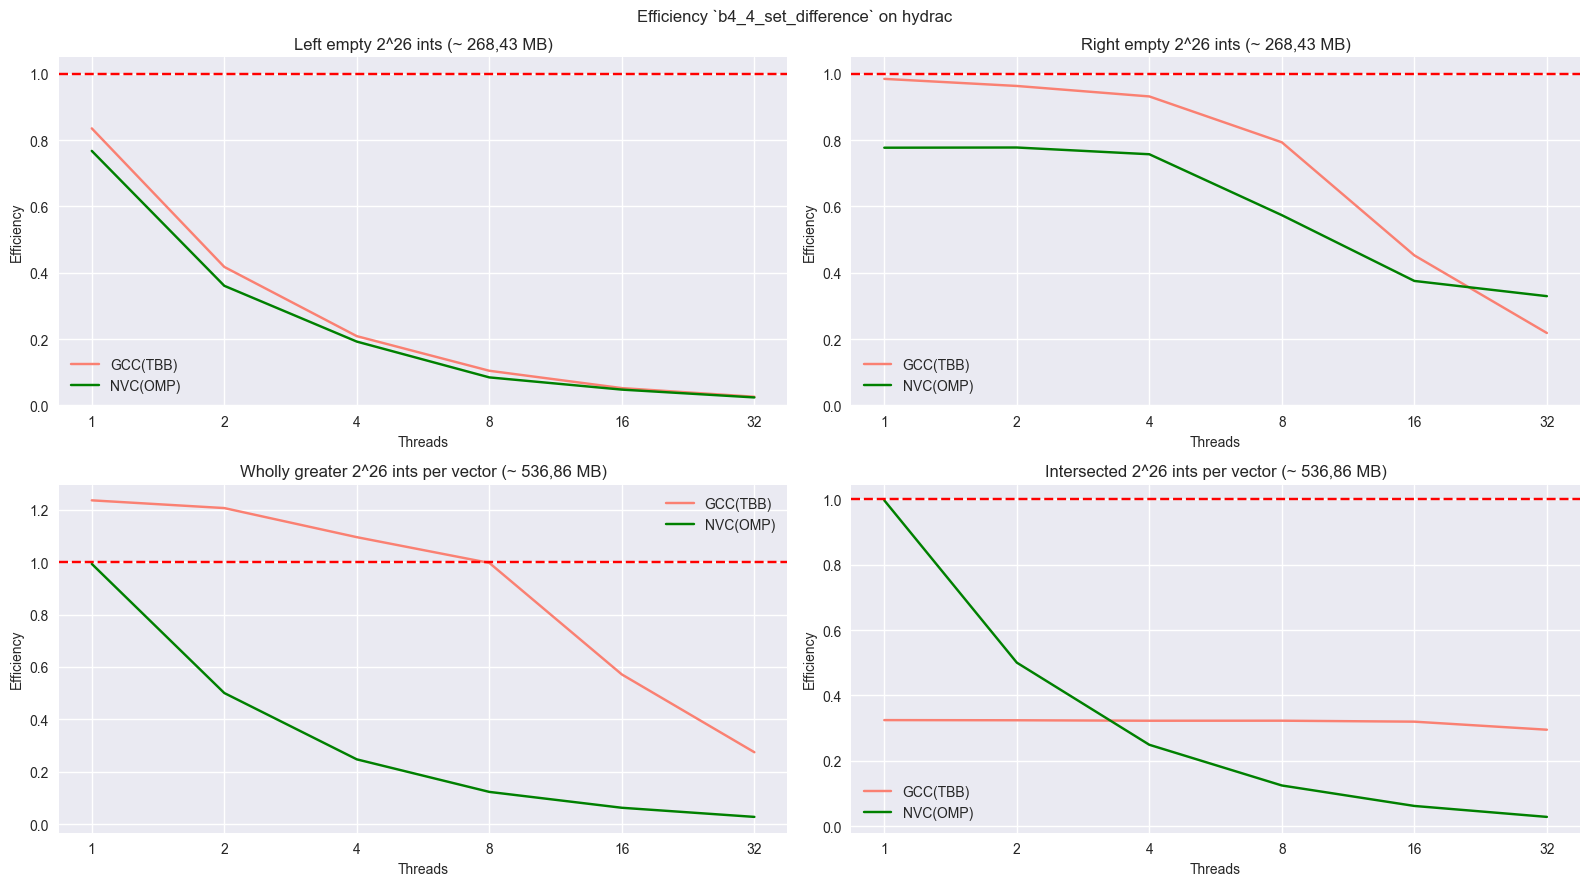

In [134]:
# efficiency graphs


fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))


# left empty
ax_1 = b4_4_set_difference_cutoff_left_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,0])

ax_1.set_ylabel('Efficiency')
ax_1.set_xlabel('Threads')
ax_1.set_title('Left empty 2^26 ints (~ 268,43 MB)')
ax_1.axhline(y=1, color='r',linestyle='--')
ax_1.set_ylim(0,1.05)

ax_1.set_xscale('log', base=2)
current_values = ax_1.get_xticks()
ax_1.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# right empty
ax_2 = b4_4_set_difference_cutoff_right_empty_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0,1])

ax_2.set_ylabel('Efficiency')
ax_2.set_xlabel('Threads')
ax_2.set_title('Right empty 2^26 ints (~ 268,43 MB)')
ax_2.axhline(y=1, color='r',linestyle='--')
ax_2.set_ylim(0,1.05)

ax_2.set_xscale('log', base=2)
current_values = ax_2.get_xticks()
ax_2.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# wholly greater
ax_3 = b4_4_set_difference_cutoff_wholly_greater_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,0])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Wholly greater 2^26 ints per vector (~ 536,86 MB)')
ax_3.axhline(y=1, color='r',linestyle='--')


ax_3.set_xscale('log', base=2)
current_values = ax_3.get_xticks()
ax_3.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


# intersected
ax_4 = b4_4_set_difference_cutoff_intersected_efficiency.plot(x='threads',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[1,1])

ax_4.set_ylabel('Efficiency')
ax_4.set_xlabel('Threads')
ax_4.set_title('Intersected 2^26 ints per vector (~ 536,86 MB)')
ax_4.axhline(y=1, color='r',linestyle='--')


ax_4.set_xscale('log', base=2)
current_values = ax_4.get_xticks()
ax_4.set_xticklabels(['{:,.0f}'.format(x) for x in current_values])




fig.suptitle(f"Efficiency `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Efficiency on {device_name}")

### Mbytes/s

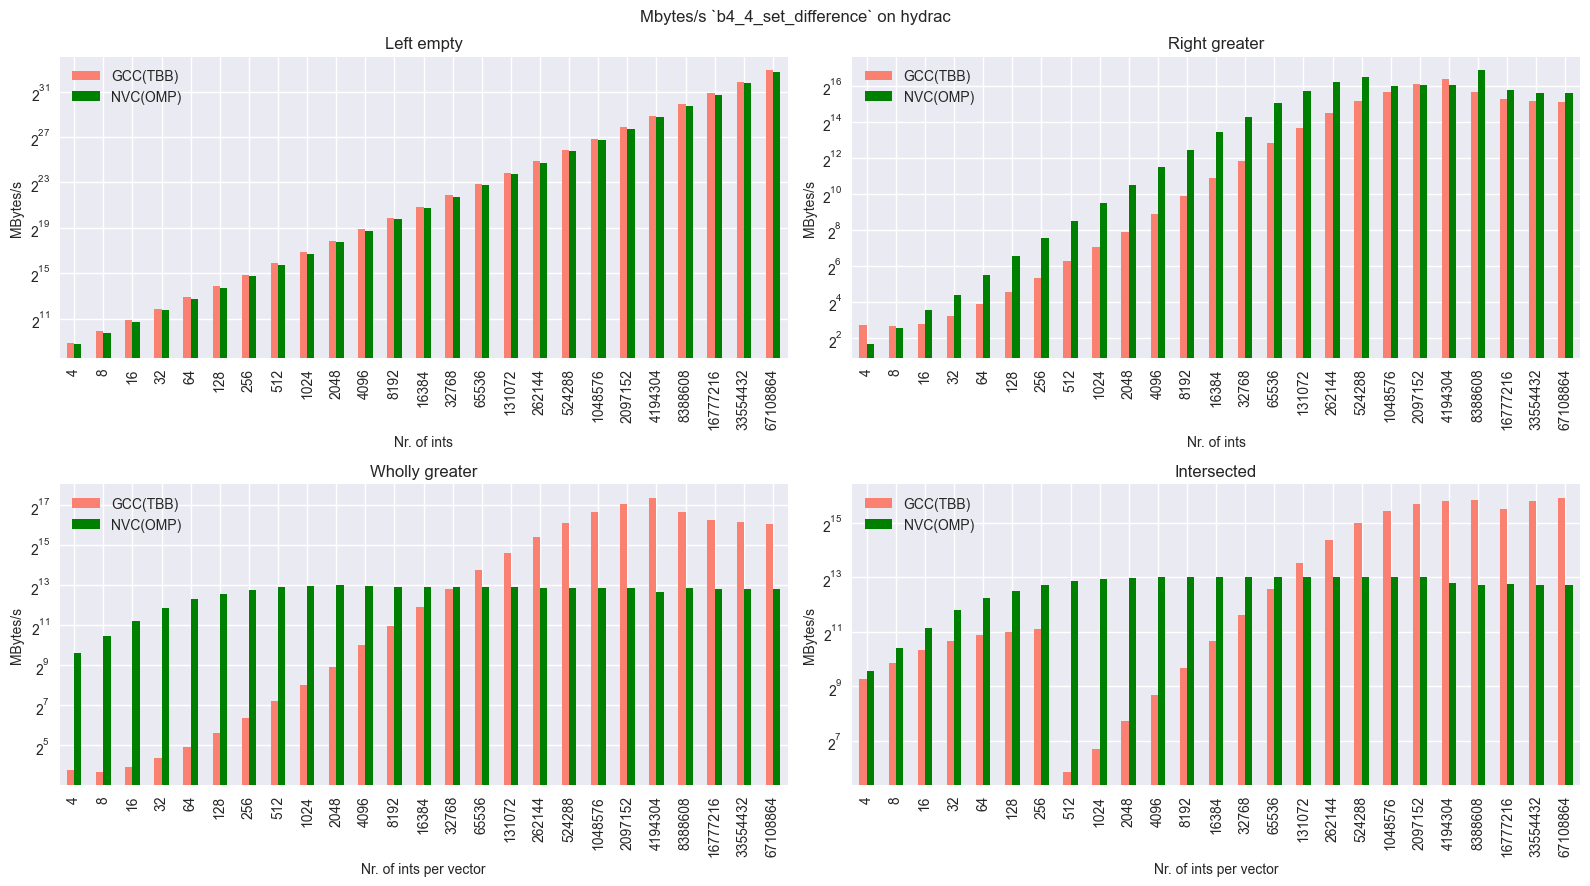

In [135]:
benchmark_names = [
    'b4_4_set_difference_cutoff_left_empty_par',
    'b4_4_set_difference_cutoff_right_empty_par',
    'b4_4_set_difference_cutoff_wholly_greater_par',
    'b4_4_set_difference_cutoff_intersected_par'
]


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

b4_4_mbytes_sec_data = {}

for benchmark_name in benchmark_names:
    # collect data for instances
    data = [bytes_per_second_data_algo(comp_location,comp_name,benchmark_name) for comp_location,comp_name in instances]

    b4_4_mbytes_sec_data[benchmark_name] = pd.merge(*data, on='n')




fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16, 9))



# plot left_empty
ax_1 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_left_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0,0]
                                                    )


ax_1.set_yscale('log',base=2)
ax_1.set_ylabel('MBytes/s')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Left empty')




# plot right empty
ax_2 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_right_empty_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[0,1]
                                                    )


ax_2.set_yscale('log',base=2)
ax_2.set_ylabel('MBytes/s')
ax_2.set_xlabel('Nr. of ints')
ax_2.set_title('Right greater')


# plot front_overhang
ax_3 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_wholly_greater_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1,0]
                                                    )

ax_3.set_yscale('log',base=2)
ax_3.set_ylabel('MBytes/s')
ax_3.set_xlabel('Nr. of ints per vector')
ax_3.set_title('Wholly greater')



# plot intersected
ax_4 = b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_intersected_par'].plot(kind='bar',
                                                        x='n',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1,1]
                                                    )

ax_4.set_yscale('log',base=2)
ax_4.set_ylabel('MBytes/s')
ax_4.set_xlabel('Nr. of ints per vector')
ax_4.set_title('Intersected')


fig.suptitle(f"Mbytes/s `b4_4_set_difference` on {device_name}")

fig.tight_layout()

plot(f"`b4_4_set_difference` Mbytes_s on {device_name}")

## Performance Portability Calculation (Inter Compiler)

In [136]:
def calc_pp(data_points:List[int]) -> int:
    max_val = max(data_points)
    return len(data_points) / sum([1/(val/max_val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('B4_1',b4_1_mbytes_sec_data),
    
    ('B4_2_already_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_already_sorted_par']),
    ('B4_2_decrement_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_decrement_sorted_par']),
    ('B4_2_not_sorted',b4_2_mbytes_sec_data['b4_2_stable_sort_cutoff_not_sorted_par']),
    
    ('b4_3_one_empty',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_empty_par']),
    ('b4_3_wholly_greater',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_one_wholly_greater_par']),
    ('b4_3_front_overhang',b4_3_mbytes_sec_data['b4_3_set_union_cutoff_front_overhang_par']),
    
    ('b4_4_left_empty',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_left_empty_par']),
    ('b4_4_right_empty',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_right_empty_par']),
    ('b4_4_wholly_greater',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_wholly_greater_par']),
    ('b4_4_intersected',b4_4_mbytes_sec_data['b4_4_set_difference_cutoff_intersected_par']),
]


for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df

,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,B4_1,19696,3508,0.302362,BAD
1,B4_2_already_sorted,2078,416,0.333601,BAD
2,B4_2_decrement_sorted,2021,394,0.326294,BAD
3,B4_2_not_sorted,952,521,0.707400,BAD
4,b4_3_one_empty,34235,45986,0.853517,GOOD
5,b4_3_wholly_greater,34394,5065,0.256722,BAD
6,b4_3_front_overhang,5666,4431,0.877686,GOOD
7,b4_4_left_empty,7804860000,7170860000,0.957665,GOOD
8,b4_4_right_empty,34783,49210,0.828236,BAD
9,b4_4_wholly_greater,68862,7131,0.187675,BAD


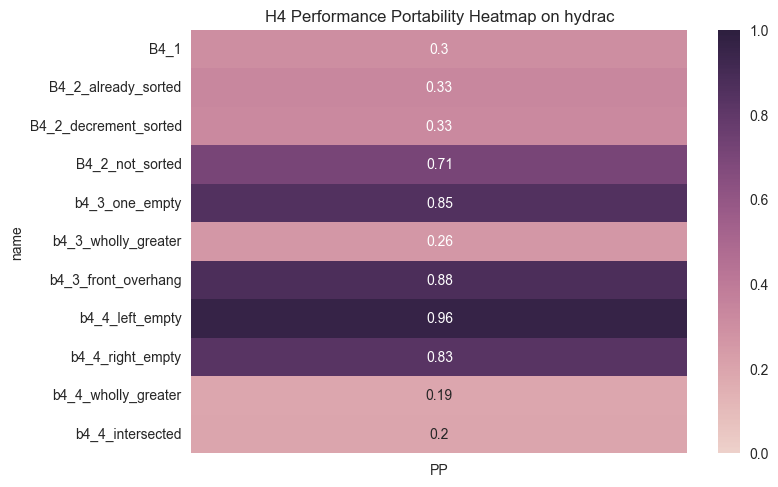

In [137]:
import seaborn as sns

heatmap_pp_df = pp_df.copy()
heatmap_pp_df = heatmap_pp_df.drop(columns=['GCC(TBB)','NVC(OMP)','INTERPRET'])
heatmap_pp_df = heatmap_pp_df.set_index(['name'])


sns.heatmap(heatmap_pp_df, annot=True,cmap=sns.cubehelix_palette(as_cmap=True),vmin=0,vmax=1)

plt.title(f'H4 Performance Portability Heatmap on {device_name}')

plot(f'H4 Performance Portability Heatmap on {device_name}')

## Findings for H4

### Findings `b4_1_merge`



### Findings `b4_2_stable_sort`



### Findings `b4_3_set_union`



### Findings `b4_4_set_difference`



### General



### GPU Findings



### Hypothesis Findings

